In [1]:
import torch
import torchvision
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [2]:
!git clone https://github.com/yiskw713/ScoreCAM.git

Cloning into 'ScoreCAM'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 2), reused 20 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), 3.29 MiB | 4.14 MiB/s, done.


In [3]:
import sys
sys.path.append('/content/ScoreCAM')

In [4]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
from ScoreCAM import cam

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torchvision.utils import save_image

from cam import CAM, GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM
from utils.visualize import visualize, reverse_normalize
from utils.imagenet_labels import label2idx, idx2label

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


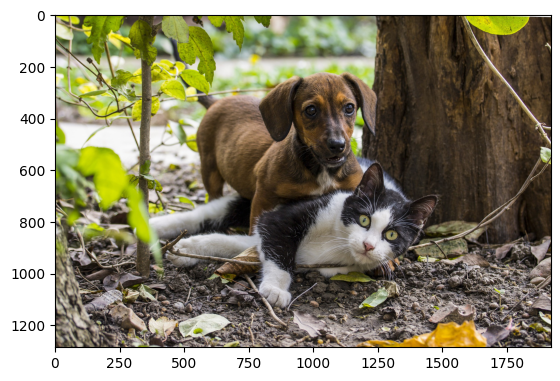

In [128]:
image = Image.open('/content/drive/MyDrive/AI Lab/dog_cat_2.jpg')
# image = keras.utils.get_file("cat_and_dog.jpg", "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",)
imshow(image)

In [129]:
from PIL import Image


# Resize the image
size = (300, 300)
image = image.resize(size)

In [130]:
# preprocessing. mean and std from ImageNet
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [131]:
# convert image to tensor
tensor = preprocess(image)

# reshape 4D tensor (N, C, H, W)
tensor = tensor.unsqueeze(0)

In [132]:
tensor.shape

torch.Size([1, 3, 300, 300])

In [133]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet18(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [134]:
target_layer = model.layer4[1].conv2
wrapped_model = ScoreCAM(model, target_layer)
cam, idx = wrapped_model(tensor)

tiger cat


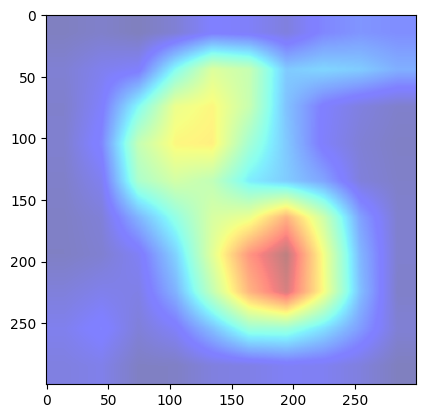

In [135]:
print(idx2label[idx])
plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
plt.show()

In [136]:
print(cam.shape)

torch.Size([1, 1, 300, 300])


In [137]:
img = reverse_normalize(tensor)
heatmap = visualize(img, cam)

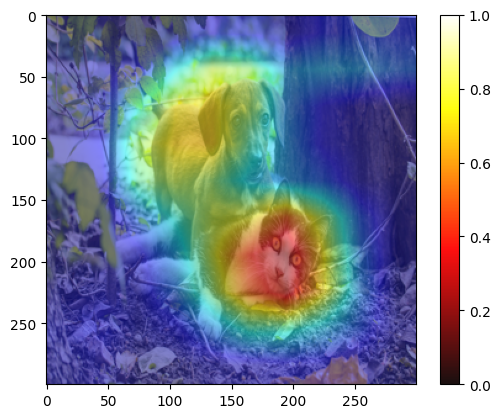

In [138]:
heatmap = (heatmap.squeeze().numpy().transpose(1, 2, 0)).astype(np.float32)
# plt.imshow(input)
plt.imshow(heatmap, cmap='hot', alpha=0.94)
plt.colorbar()
plt.show()

In [26]:
!pip install saliency-maps-metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from saliency_maps_metrics.single_step_metrics import IIC_AD, ADD 
from saliency_maps_metrics.multi_step_metrics import Deletion, Insertion

#Single Step Metrics
- Increase In Confidence (IIC), Average Drop (AD) and Average Drop in Deletion (ADD) metrics

In [139]:
iic_ad = IIC_AD()
result_dic = iic_ad(model,tensor,cam,idx)  
iic_mean,ad_mean = result_dic["iic"],result_dic["ad"]
print("IIC",iic_mean)
print("AD",ad_mean)


IIC 0.0
AD 0.14847155


In [140]:
add = ADD()
result_dic = add(model,tensor,cam,idx) 
add_mean = result_dic["add"]
print("ADD",add_mean)

ADD 0.13147248


#Multi-Step Metrics
- Deletion Area Under the Curve (DAUC), Insertion Area Under the Curve (IAUC), Deletion Correlation (DC) and Insertion Correlation (IC)

In [141]:
cam = torch.nn.functional.interpolate(cam,(3,3))

In [142]:
print(idx)

282


In [143]:
deletion = Deletion(data_replace_method="black", bound_max_step=True, batch_size=20, max_step_nb=14*14, cumulative=True)

scalar_tensor = torch.tensor(idx)
idx1 = torch.unsqueeze(scalar_tensor, 0)
result_dic = deletion(model,tensor,cam,idx1)
dauc = result_dic["dauc"]
dc = result_dic["dc"]
print("DAUC",dauc)
print("DC",dc)

DAUC 2.534717629353205
DC -0.13867827010272052


In [144]:
insertion = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=20, max_step_nb=14*14, cumulative=True)
scalar_tensor = torch.tensor(idx)
idx2 = torch.unsqueeze(scalar_tensor, 0)
result_dic = insertion(model,tensor.clone(),cam.clone(),idx2)
iauc_mean = result_dic["iauc"]
ic_mean = result_dic["ic"]
print("IAUC",iauc_mean) 
print("IC",ic_mean)

IAUC 2.992755386564467
IC 0.05678172522366329


#Same as on Github Link
https://github.com/TristanGomez44/metrics-saliency-maps/tree/main

In [145]:
import torch 
from torch.nn import Module,Sequential,Softmax
import torchvision 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt 
from captum.attr import LayerGradCam,LayerAttribution

from saliency_maps_metrics.single_step_metrics import IIC_AD, ADD 
from saliency_maps_metrics.multi_step_metrics import Deletion, Insertion

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


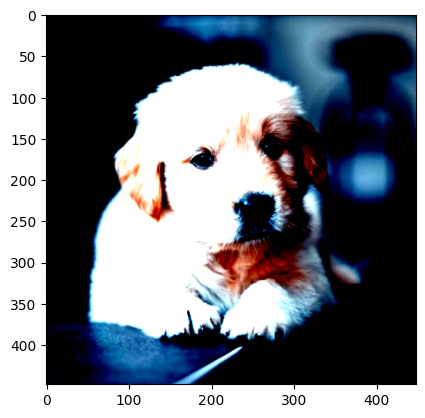

In [146]:
val_batch_size = 10

cropped_img_size = 448
img_size=int(cropped_img_size / 0.875)

transf = [transforms.Resize(img_size),transforms.CenterCrop(cropped_img_size)]
transf.extend([transforms.ToTensor()])
transf.extend([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transf = transforms.Compose(transf)

test_dataset = ImageFolder("/content/drive/MyDrive/AI Lab/",transform=transf)
testLoader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=val_batch_size,num_workers=4,pin_memory=True,shuffle=True)

batch = test_dataset.__getitem__(0)
plt.figure()
plt.imshow(batch[0].permute(1,2,0).numpy())
plt.show()

In [147]:
model1 = torchvision.models.resnet50(pretrained=True)
# model.load_state_dict(torch.load("model_cub.pth",map_location="cpu"))
model1 = model.eval()
model1 = Sequential(model,Softmax(dim=-1))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


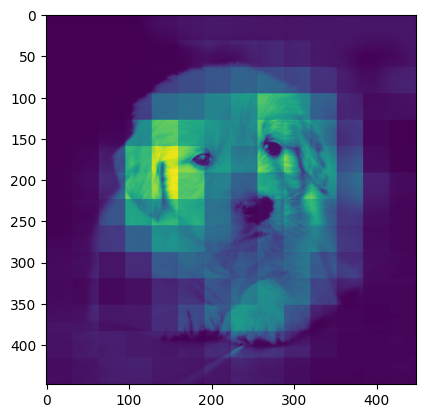

In [149]:
gradcam = LayerGradCam(model1,getattr(model1,"0").layer4)

batch = test_dataset.__getitem__(0)[0].unsqueeze(0)
class_ind = model1(batch).argmax(dim=-1)
attr = gradcam.attribute(batch,class_ind)
upsampled_attr = LayerAttribution.interpolate(attr, (448, 448))

upsampled_attr = (upsampled_attr - upsampled_attr.min())/(upsampled_attr.max()-upsampled_attr.min())
batch = (batch - batch.min())/(batch.max()-batch.min())

img_to_viz = (upsampled_attr*batch.mean(dim=1,keepdim=True)).detach()
img_to_viz = img_to_viz[0].permute(1,2,0)

plt.figure()
plt.imshow(img_to_viz)
plt.show()

In [150]:
torch.manual_seed(0)
inds = torch.randint(size=(1,),high=len(test_dataset))

allImg = []
allExpl = []
allInds = []

for ind in inds:
    
    batch = test_dataset.__getitem__(ind)
    img = batch[0].unsqueeze(0)
    class_ind = model(img).argmax(dim=-1)
    attr = gradcam.attribute(img,class_ind)
    
    allImg.append(img)
    allExpl.append(attr)
    allInds.append(class_ind)

allImg = torch.cat(allImg,dim=0)
allExpl = torch.cat(allExpl,dim=0)
allInds = torch.cat(allInds,dim=0)

In [151]:
iic_ad = IIC_AD()
result_dic = iic_ad(model,allImg,allExpl,allInds)  
iic_mean,ad_mean = result_dic["iic"],result_dic["ad"]
print("IIC",iic_mean)
print("AD",ad_mean)

add = ADD()
result_dic = add(model,allImg,allExpl,allInds) 
add_mean = result_dic["add"]
print("ADD",add_mean)
    

IIC 0.0
AD 0.28651306
ADD 0.03279356


In [152]:
allExpl = torch.nn.functional.interpolate(allExpl,(3,3))

# deletion = Deletion(allImg.shape,allExpl.shape)
deletion_metric = Deletion(data_replace_method="black", bound_max_step=True, batch_size=20, max_step_nb=14*14, cumulative=True)
result_dic = deletion(model,allImg.clone(),allExpl.clone(),allInds)
dauc_mean = result_dic["dauc"]
dc_mean = result_dic["dc"]
print("DAUC",dauc_mean)
print("DC",dc_mean)

insertion = Insertion(data_replace_method="blur", bound_max_step=True, batch_size=20, max_step_nb=14*14, cumulative=True)
result_dic = insertion(model,allImg.clone(),allExpl.clone(),allInds)
iauc_mean = result_dic["iauc"]
ic_mean = result_dic["ic"]
print("IAUC",iauc_mean) 
print("IC",ic_mean)

DAUC 5.9295233024491205
DC -0.3843783703084482
IAUC 6.667961941825019
IC 0.5364844825263808
